In [49]:
import os
import random
import warnings
from collections import defaultdict
from glob import glob
from pprint import pprint

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import (GRU, LSTM, AveragePooling2D, Conv2D,
                                     Dense, Flatten, Input, MaxPooling2D,
                                     Permute, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

In [2]:
TEST_IMAGES_PATH = '../data/processed/test/'
TRAIN_CSV_PATH = '../data/raw/train/corrected_train_data.csv'
TRAIN_IMAGES_PATH = '../data/processed/train/'
RANDOM_STATE = 42

In [3]:
PUBLIC_host = 'http://13.234.225.243'
SUBMISSION_URL = PUBLIC_host + ':8080/submit'
LEADERBOARD_URL = PUBLIC_host + ':8080/leaderboard'
DATA_URL = PUBLIC_host + ':9600'

In [4]:
date_range = (0, 8)
image_inp_shape = (100, 450, 1)
tag = "deepak_starter_notebook_v5"

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"


seed_everything(RANDOM_STATE)

In [6]:
train_df = pd.read_csv(TRAIN_CSV_PATH, dtype=str)

In [7]:
def model(inp_shape=(100, 450, 1), num_outs=8):
    inp = Input(shape=inp_shape)

    c = Conv2D(8, (3, 3), activation="relu")(inp)
    # c = MaxPooling2D((2,3))(c)
    c = AveragePooling2D((2, 3))(c)

    c = Conv2D(1, (3, 3), activation="relu")(c)
    # c = MaxPooling2D((2,3))(c)
    c = AveragePooling2D((2, 3))(c)

    r = Reshape((int(c.shape[1]), int(c.shape[2])))(c)
    p = Permute((2, 1))(r)

    shared_softmax = Dense(10, activation="softmax")

    outs = []
    for xx in range(num_outs):
        l = LSTM(20, return_sequences=True)(p)
        f = Flatten()(l)
        s = shared_softmax(f)
        outs.append(s)
    if num_outs == 1:
        outs = outs[0]
    model = Model(inputs=inp, outputs=outs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [8]:
def generator(
    batch_size=32,
    image_inp_shape=(450, 100),
    rand_flag=True,
    mode="train",
    train_ratio=0.8,
    date_range=(0, 7),
):
    images_files = glob(TRAIN_IMAGES_PATH + "/*.png")
    train_size = int(len(images_files) * train_ratio)
    images_files = (
        images_files[:train_size] if mode == "train" else images_files[train_size:]
    )
    iter_count = 0
    while True:
        try:
            if rand_flag:
                x_batch = random.sample(images_files, batch_size)
            else:
                x_batch = images_files[
                    iter_count * batch_size : iter_count * batch_size + batch_size
                ]
            iter_count += 1
            y_batch = list(
                map(
                    lambda x: train_df.loc[
                        train_df["tag"] == x.split("/")[-1].split(".")[0]
                    ]["label"].item(),
                    x_batch,
                )
            )
            x_batch = np.array(
                list(
                    map(
                        lambda x: np.expand_dims(
                            cv2.resize(cv2.imread(x, 0), (image_inp_shape)), -1
                        ),
                        x_batch,
                    )
                )
            )
            y_batch = np.eye(10)[
                list(
                    map(
                        lambda x: list(
                            map(
                                lambda xx: int(xx),
                                list(x)[date_range[0] : date_range[1]],
                            )
                        ),
                        y_batch,
                    )
                )
            ]
            y_batch = list(np.swapaxes(y_batch, 0, 1))

            if date_range[1] - date_range[0] == 1:
                y_batch = y_batch[0]

            yield (x_batch, y_batch)
        except Exception as e:
            print(e)
            continue

In [9]:
m = model(inp_shape=image_inp_shape, num_outs=date_range[1] - date_range[0])

In [10]:
m.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 450, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 448, 8)   80          input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 49, 149, 8)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 147, 1)   73          average_pooling2d[0][0]          
_______________________________________________________________________________________

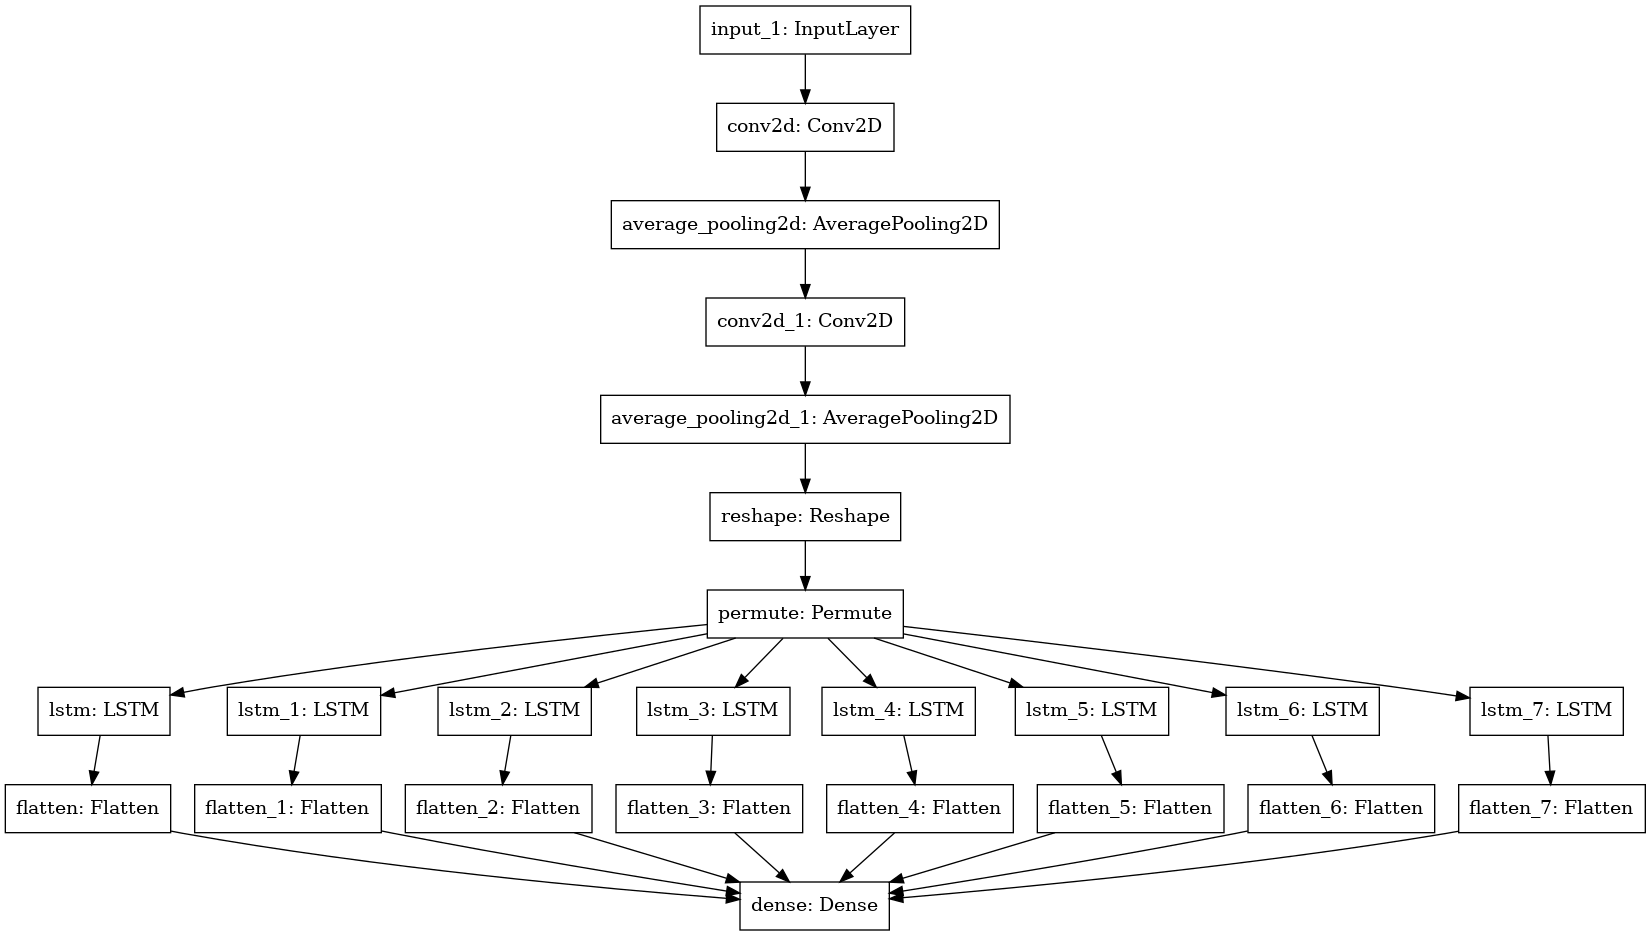

In [11]:
plot_model(m)

In [12]:
model_file_path = f"../models/{tag}_{date_range[0]}-{date_range[1]}.h5"

# callbacks
cbk = ModelCheckpoint(
    model_file_path, monitor="val_loss", save_weights_only=False, save_best_only=True
)
log = CSVLogger(f"../logs/{tag}.log")

# training
m.fit(
    generator(image_inp_shape=(450, 100), date_range=date_range),
    epochs=3,
    steps_per_epoch=300,
    validation_data=generator(
        image_inp_shape=(450, 100), rand_flag=True, mode="val", date_range=date_range
    ),
    validation_steps=100,
    callbacks=[cbk, log],
)

Epoch 1/3
300/300 [==============================] - 205s 684ms/step - loss: 12.5482 - dense_loss: 2.3157 - dense_1_loss: 2.3392 - dense_2_loss: 2.3346 - dense_3_loss: 2.3371 - dense_4_loss: 1.6591 - dense_5_loss: 0.7712 - dense_6_loss: 0.7682 - dense_7_loss: 0.0232 - dense_accuracy: 0.1276 - dense_1_accuracy: 0.1203 - dense_2_accuracy: 0.1119 - dense_3_accuracy: 0.1067 - dense_4_accuracy: 0.2203 - dense_5_accuracy: 0.5458 - dense_6_accuracy: 0.5929 - dense_7_accuracy: 0.9957 - val_loss: 12.1247 - val_dense_loss: 2.2976 - val_dense_1_loss: 2.3326 - val_dense_2_loss: 2.3083 - val_dense_3_loss: 2.3065 - val_dense_4_loss: 1.6328 - val_dense_5_loss: 0.6569 - val_dense_6_loss: 0.5891 - val_dense_7_loss: 9.9742e-04 - val_dense_accuracy: 0.1531 - val_dense_1_accuracy: 0.1122 - val_dense_2_accuracy: 0.1278 - val_dense_3_accuracy: 0.1194 - val_dense_4_accuracy: 0.2172 - val_dense_5_accuracy: 0.5866 - val_dense_6_accuracy: 0.7234 - val_dense_7_accuracy: 1.0000
Epoch 2/3
300/300 [================

In [13]:
# m = load_model(model_file_path)
images_files = glob(TEST_IMAGES_PATH + "/*.png")

s_dict = defaultdict(list)
for image_file in tqdm(images_files):
    x_test = np.expand_dims(cv2.resize(cv2.imread(image_file, 0), (450, 100)), -1)
    pred = m.predict(np.array([x_test]))
    pred_label = "".join(list(map(lambda x: str(np.argmax(x)), pred)))
    s_dict["tag"].append(image_file.split("/")[-1].split(".")[0])
    s_dict["label"].append(pred_label)

sub_df = pd.DataFrame(s_dict)

100%|██████████| 1000/1000 [01:24<00:00, 11.86it/s]


In [43]:
sub_df["tag"] = sub_df["tag"].astype("int")
sub_df = sub_df.sort_values(by="tag")

In [61]:
sub_df[10:20].head()

,tag,label
777,10,35563771
456,11,65186871
701,12,95133881
873,13,15883881
274,14,60863871


In [63]:
def plot_grid(files, labels=None, h=6, w=6, title=""):
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    for idx, path in enumerate(random.choices(files, k=h*w)):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, 3)
        image = tf.cast(image/255, tf.float32)
        image_number = path.split("/")[-1].split(".")[0]
        label = labels.loc[labels["tag"]==int(image_number)]["label"].values[0]

        ax[idx // h, idx % w].imshow(image)
        ax[idx // h, idx % w].axis("off")
        ax[idx // h, idx % w].set_title(f"Image: {image_number} Label: {label}")
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

In [64]:
test_files = glob(os.path.join("../data/processed/test", "*.png"))

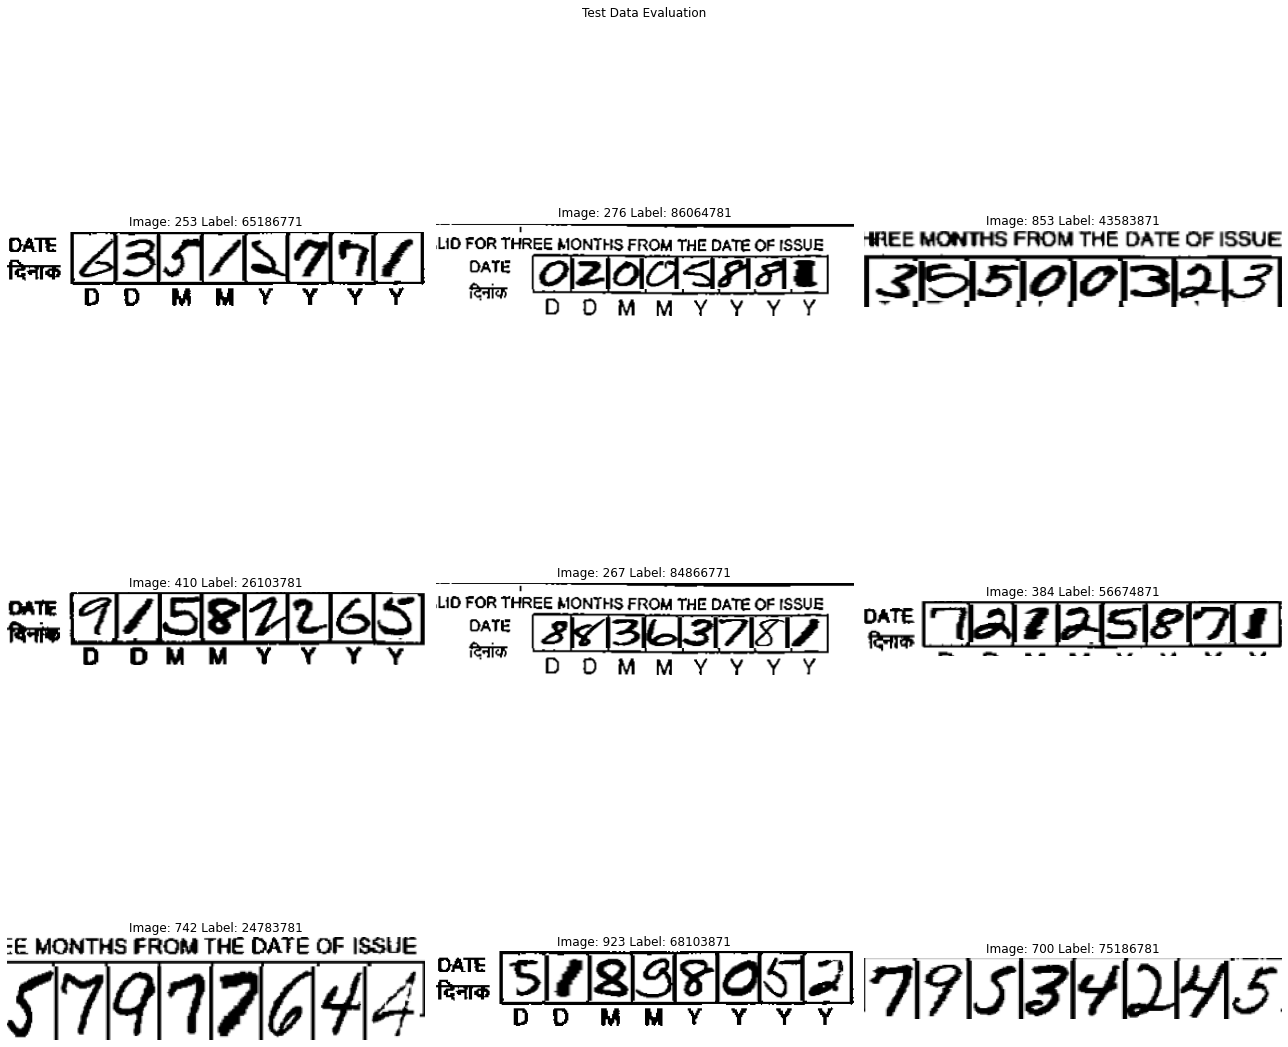

In [65]:
plot_grid(test_files, sub_df, h=3, w=3, title="Test Data Evaluation")

In [66]:
sub_df.to_csv(f"../submissions/{tag}.csv", index=False)

In [67]:
sub_json = sub_df.to_json()
data = {
    "username": "deepak",
    "password": "xxxx",
    "submission": sub_json,
    "tag": tag,
}
# r = requests.post(SUBMISSION_URL, json=data)

In [68]:
# r.text

In [69]:
rl = requests.post(LEADERBOARD_URL, json={})
pprint(rl.json())

{'leaderboard': [{'score': 0.0,
                  'submitted_at': '2020-10-24-06-36-1603521407',
                  'tag': 'test2',
                  'username': 'deepak'}],
 'success': True}


**Comparing different versions**

In [70]:
!ls ../logs

deepak_starter_notebook_v4.log	deepak_starter_notebook_v5.log


In [71]:
v1 = pd.read_csv("../logs/deepak_starter_notebook_v4.log")
v2 = pd.read_csv("../logs/deepak_starter_notebook_v5.log")

In [72]:
loss_cols, acc_cols, val_loss, val_acc = [], [], [], []

In [73]:
for col in v1.columns:
    if "accuracy" in col and "val" in col:
        val_acc.append(col)
    elif "loss" in col and "val" in col:
        val_loss.append(col)
    elif "accuracy" in col:
        acc_cols.append(col)
    else:
        loss_cols.append(col)

In [74]:
v1[acc_cols]

,dense_1_accuracy,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,dense_5_accuracy,dense_6_accuracy,dense_7_accuracy,dense_accuracy
0,0.116667,0.118750,0.102812,0.231771,0.534792,0.546042,0.995625,0.116042
1,0.121458,0.146875,0.108854,0.287500,0.694271,0.718333,1.000000,0.120208
2,0.154375,0.167396,0.130313,0.355729,0.787396,0.779271,1.000000,0.147813


In [75]:
v2[acc_cols]

,dense_1_accuracy,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,dense_5_accuracy,dense_6_accuracy,dense_7_accuracy,dense_accuracy
0,0.120312,0.111875,0.106667,0.220313,0.545833,0.592917,0.995729,0.127604
1,0.143438,0.140729,0.127500,0.263646,0.690313,0.736562,1.000000,0.163125
2,0.177813,0.167604,0.153854,0.333750,0.789583,0.797917,1.000000,0.210625


*Mean Accuracy Improvement per Layer*

In [76]:
inter = v2[acc_cols]-v1[acc_cols]
inter.mean()

dense_1_accuracy    0.016354
dense_2_accuracy   -0.004271
dense_3_accuracy    0.015347
dense_4_accuracy   -0.019097
dense_5_accuracy    0.003090
dense_6_accuracy    0.027917
dense_7_accuracy    0.000035
dense_accuracy      0.039097
dtype: float64

In [77]:
print(f"Total Improvement: {inter.mean().mean():.4}")

Total Improvement: 0.009809


**v3 provides better training accuracy for each layer prediction per epoch**

In [78]:
v1[val_acc]

,val_dense_1_accuracy,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,val_dense_5_accuracy,val_dense_6_accuracy,val_dense_7_accuracy,val_dense_accuracy
0,0.120625,0.116250,0.113438,0.222500,0.568438,0.65500,1.0,0.124688
1,0.130625,0.135000,0.104687,0.310625,0.760312,0.74375,1.0,0.115938
2,0.178125,0.164687,0.117188,0.390000,0.829687,0.81125,1.0,0.156250


In [79]:
v2[val_acc]

,val_dense_1_accuracy,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,val_dense_5_accuracy,val_dense_6_accuracy,val_dense_7_accuracy,val_dense_accuracy
0,0.112187,0.127813,0.119375,0.217187,0.586563,0.723437,1.0,0.153125
1,0.160313,0.158125,0.121563,0.293750,0.773438,0.747187,1.0,0.183750
2,0.182812,0.165625,0.141563,0.336875,0.817500,0.795000,1.0,0.210625


*Mean Accuracy Improvement per Layer*

In [80]:
inter = v2[val_acc]-v1[val_acc]
inter.mean()

val_dense_1_accuracy    0.008646
val_dense_2_accuracy    0.011875
val_dense_3_accuracy    0.015729
val_dense_4_accuracy   -0.025104
val_dense_5_accuracy    0.006354
val_dense_6_accuracy    0.018542
val_dense_7_accuracy    0.000000
val_dense_accuracy      0.050208
dtype: float64

In [81]:
print(f"Total Improvement: {inter.mean().mean():.4}")

Total Improvement: 0.01078


**v3 provides better validation accuracy for each layer prediction per epoch**

In [82]:
v1[loss_cols]

,epoch,dense_1_loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_6_loss,dense_7_loss,dense_loss,loss
0,0,2.332853,2.332899,2.345359,1.650126,0.778503,0.797140,0.023301,2.339688,12.599868
1,1,2.305687,2.276895,2.314586,1.571141,0.594007,0.578361,0.000622,2.305250,11.946549
2,2,2.263404,2.244451,2.298508,1.496235,0.483826,0.498117,0.000345,2.272978,11.557858


In [83]:
v2[loss_cols]

,epoch,dense_1_loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_6_loss,dense_7_loss,dense_loss,loss
0,0,2.339188,2.334615,2.337059,1.659097,0.771204,0.768232,0.023179,2.315674,12.548248
1,1,2.289576,2.280620,2.299055,1.585902,0.597556,0.546209,0.000669,2.243940,11.843526
2,2,2.232060,2.236161,2.260260,1.518210,0.490375,0.462694,0.000724,2.167120,11.367603


*Mean Loss Decrease per Layer*

In [84]:
inter = v2[loss_cols]-v1[loss_cols]
inter.mean()

epoch           0.000000
dense_1_loss   -0.013707
dense_2_loss   -0.000950
dense_3_loss   -0.020693
dense_4_loss    0.015236
dense_5_loss    0.000933
dense_6_loss   -0.032161
dense_7_loss    0.000101
dense_loss     -0.063727
loss           -0.114966
dtype: float64

In [85]:
print(f"Total Loss Decrease: {inter.mean().mean():.4}")

Total Loss Decrease: -0.02299


In [86]:
v1[val_loss]

,val_dense_1_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_6_loss,val_dense_7_loss,val_dense_loss,val_loss
0,2.322343,2.312643,2.309429,1.638951,0.662055,0.632702,0.000814,2.324605,12.203543
1,2.304349,2.279617,2.309250,1.552584,0.540794,0.536700,0.000559,2.317857,11.841709
2,2.226177,2.241724,2.318818,1.454755,0.427919,0.458808,0.000242,2.268129,11.396570


In [87]:
v2[val_loss]

,val_dense_1_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_6_loss,val_dense_7_loss,val_dense_loss,val_loss
0,2.332552,2.308309,2.306453,1.632787,0.656941,0.589081,0.000997,2.297602,12.124724
1,2.305007,2.282011,2.310390,1.565271,0.526428,0.535267,0.001005,2.243764,11.769144
2,2.243914,2.249503,2.285506,1.513489,0.445334,0.465426,0.000518,2.187565,11.391254


*Mean Loss Decrease per Layer*

In [88]:
inter = v2[val_loss]-v1[val_loss]
inter.mean()

val_dense_1_loss    0.009535
val_dense_2_loss    0.001946
val_dense_3_loss   -0.011716
val_dense_4_loss    0.021752
val_dense_5_loss   -0.000688
val_dense_6_loss   -0.012812
val_dense_7_loss    0.000302
val_dense_loss     -0.060553
val_loss           -0.052233
dtype: float64

In [89]:
print(f"Total Loss Decrease: {inter.mean().mean():.4}")

Total Loss Decrease: -0.01161
